# Calculating the customer lifetime value for an online retail store

This CLV makes use of the lifetimes package down the line, so please make sure that you have this package installed on your local device: !pip install lifetimes

The lifetimes package is a library made for CLV purposes.

In [1]:
#Importing the libraries
import pandas as pd
import matplotlib as plt
from lifetimes.plotting import *
from lifetimes.utils import *


#Importing the data
df = pd.read_excel("OnlineRetail.xlsx", encoding="cp1252")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# Checking the shape of the data set
df.shape

(541909, 8)

In [3]:
# Mark the missing data 
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Removing the timestamp frome the invoice date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%Y/%m/%d").dt.date

In [5]:
# There are 135,080 missing values in the customer ID column.
# As the CLV analysis serves the identification of the value of the existing customers
# we will drop the missing values ergo the non-identificable customers
# as they do not complement this analysis

df = df[pd.notnull(df['CustomerID'])]

# Only keeping rows where the order quantity is above 0.
df = df[(df['Quantity']>0)]

# Feature engineering an new column "Total Sales" from "Quantity"*"UnitPrice"
df['Total_Sales'] = df['Quantity'] * df['UnitPrice']

# Disregarding unnecessary columns
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
df = df[necessary_cols]
df.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [6]:
# Counting the records based on unique customer ID's
print(df['CustomerID'].nunique())

4339


In [7]:
# Checking the last order date for a specific Customer ID
# Here it is customer ID 12346
last_order_date = df['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(df[(df['CustomerID']==12346)])

2011-12-09
--------------------------------------
       CustomerID InvoiceDate  Total_Sales
61619     12346.0  2011-01-18      77183.6


In [8]:
# Creating the CLV table lf_df
lf_df = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_df.reset_index().head(10)

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000
5,12352.0,6.0,260.0,296.0,368.256667
6,12353.0,0.0,0.0,204.0,0.000000
7,12354.0,0.0,0.0,232.0,0.000000
8,12355.0,0.0,0.0,214.0,0.000000
9,12356.0,2.0,303.0,325.0,269.905000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchasing only once: 35.7 %


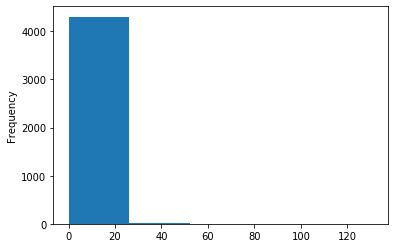

In [9]:
%matplotlib inline
#Creating a histogram to find out how many customers purchased only once.
lf_df['frequency'].plot(kind='hist', bins=5)
print(lf_df['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_df['frequency'] == 0)/float(len(lf_df))*(100),2)
print("Percentage of customers purchasing only once:", one_time_buyers ,"%")

In [10]:
# Shortlisting the number of returning customers. 
shortlisted_customers = lf_df[lf_df['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value
0     12347.0        6.0    365.0  367.0      599.701667
1     12348.0        3.0    283.0  358.0      301.480000
2     12352.0        6.0    260.0  296.0      368.256667
3     12356.0        2.0    303.0  325.0      269.905000
4     12358.0        1.0    149.0  150.0      683.200000
-----------------------------------------
The Number of Returning Customers are:  2790


In [11]:
# Frequency/Recency Analysis using the BG/NBD model of the lifetimes package
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_df['frequency'], lf_df['recency'], lf_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [12]:
# Printing out the mathematical summary of the BG/NBD model calculation.
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


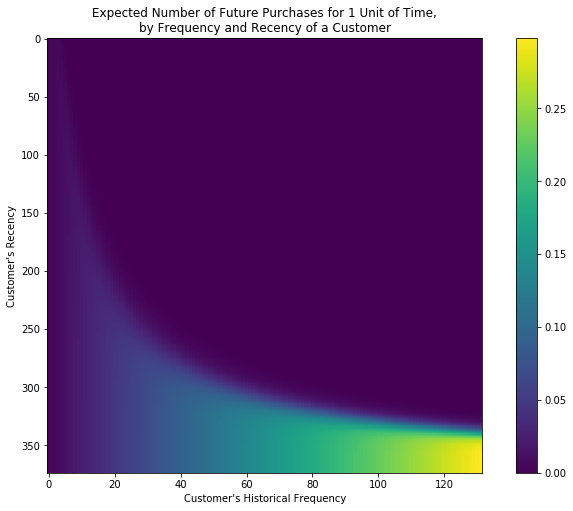

In [13]:
# Visualizing the frequency/recency matrix
# This shall represent the probability of a customer purchasing a product
# given a specific time unit
# Yellow represents the highest probability

%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

You can notice that the probability of a purchase given a specific time unit strongly depends on the historical order frequency. The recency is less important as a factor but still worth noting.

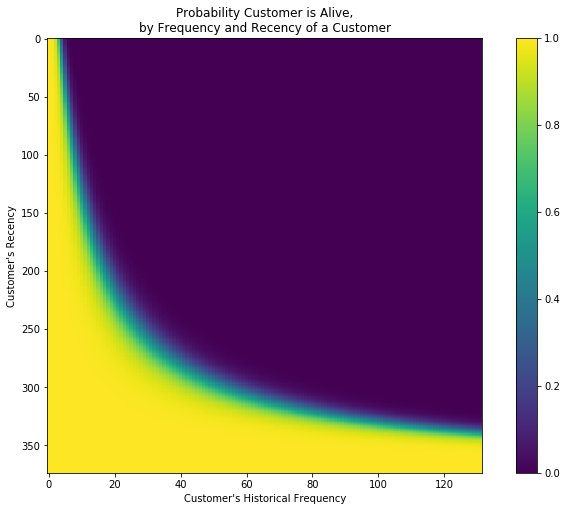

In [14]:
# Predicting the aliveness of the customer for the business
# Yellow represents an almost certain aliveness
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [15]:
# Predicting the future transactions for the next twenty days
# Then display the 10 customers most likely to purchase during that time period
# based on the historical data

t = 20
lf_df['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_df['frequency'], lf_df['recency'], lf_df['T']),2)
lf_df.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,5.97
1,12748.0,113.0,373.0,373.0,298.360885,5.15
2,17841.0,111.0,372.0,373.0,364.452162,5.06
3,15311.0,89.0,373.0,373.0,677.729438,4.07
4,14606.0,88.0,372.0,373.0,135.890114,4.02
5,12971.0,70.0,369.0,372.0,159.211286,3.21
6,13089.0,65.0,367.0,369.0,893.714308,3.01
7,14527.0,53.0,367.0,369.0,155.016415,2.46
8,13798.0,52.0,371.0,372.0,706.650962,2.40
9,16422.0,47.0,352.0,369.0,702.472340,2.18


In this table you can see that the customer with the ID 14911 is expected to order 5,97 products (see column pred_num_tx) in the given 20-day-timeframe, followed by customer ID 12748. If you have a look at the table it becomes clear that the frequency and recency factors give the weight for the prediction, like you saw in the frequency/recency-matrix above.

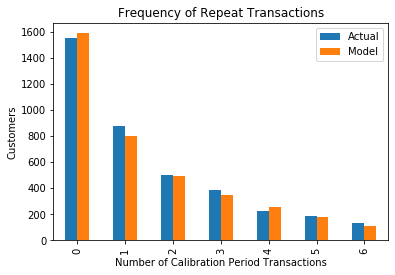

In [16]:
# Assessing the model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [17]:
# Individual customer's predicted transaction for the next 20 days
# The customer ID observed here is number 14911

t = 20
individual = lf_df.loc[17841]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

# The model predicts that the customer with the ID 14911 will make 5.06 transactions
# in the next 20 days

5.060706715356103

In [18]:
# Checking if there is a correlation between monetary value and frequency 
# in order to use the gamma model for the total CLV calculation.

lf_df[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [19]:
# Traiing the gamma model by monetary_value.
# only for the returning customers we shortlisted earlier
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [20]:
# Calculating the estimated average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_df['frequency'],
        lf_df['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [21]:
lf_df['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_df['frequency'],
        lf_df['monetary_value']), 2)
lf_df.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.04,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.31,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.18,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.19,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.04,416.92


In [22]:
# Calculating Customer Lifetime Value for the returning customers
lf_df['CLV'] = round(ggf.customer_lifetime_value(
    bgf, # future prediciton model
    lf_df['frequency'],
    lf_df['recency'],
    lf_df['T'],
    lf_df['monetary_value'],
    time=12, # in months
    discount_rate=0.01 # monthly discount rate
), 2)

lf_df.drop(lf_df.iloc[:, 0:6], inplace=True, axis=1)

lf_df.sort_values(by='CLV', ascending=False).head(10).reset_index()

,CustomerID,CLV
0,14646.0,222128.93
1,18102.0,178895.33
2,16446.0,175531.47
3,17450.0,147476.62
4,14096.0,127589.20
5,14911.0,109442.13
6,12415.0,96290.23
7,14156.0,89410.33
8,17511.0,67660.41
9,16029.0,58729.62
